Część 1

Wykonaj wykresy pudełkowe (ang.box plot), które pozwolą na graficzną identyfikację wartości odstających poprzez przedstawienie kwartyli i wartości skrajnych w danych dotyczących:

In [60]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from google.cloud import bigquery
import db_dtypes
import seaborn as sns


In [61]:
os.environ[
    "GOOGLE_APPLICATION_CREDENTIALS"] = "the-webbing-454111-s0-9a04cc92eadc.json"  # lokalizacja pobranego klucza z punktu 1.4.
client = bigquery.Client()

In [55]:
query = """
SELECT DISTINCT
    country_name,
    iso_3166_1_alpha_3 AS `3 letter country code`,
    AVG(new_deceased) AS `new_deceased`,
    AVG(new_confirmed) AS `new_confirmed`,
    AVG(new_persons_vaccinated) AS `new_persons_vaccinated`,
    MAX(population) AS `population`, 
    MAX(gdp_usd) AS `GDP`, 
    MAX(health_expenditure_usd) AS `health_expenditure_usd`,
    AVG(population_density) AS `population density`, 
    CASE 
        WHEN SUM(new_confirmed) = 0 THEN 0 
        ELSE (SUM(new_deceased) * 100) / SUM(new_confirmed) 
    END AS `Deceased to Confirmed cases %`, 
    date,
FROM 
    `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE 
    aggregation_level = 0
GROUP BY 
    country_name, iso_3166_1_alpha_3, date
ORDER BY 
    country_name
"""
query_disease = client.query(query)
query_disease_result = query_disease.result()
disease_df = query_disease_result.to_dataframe()
disease_df.dropna(inplace=True)
disease_df.to_csv('results\\prepared_for_2_ex.csv', index=False)

merged_data_df = pd.read_csv('results\\prepared_for_2_ex.csv')

1.1. liczby nowych zachorowań
1.2. liczby nowych śmierci
1.3. liczby nowych szczepień

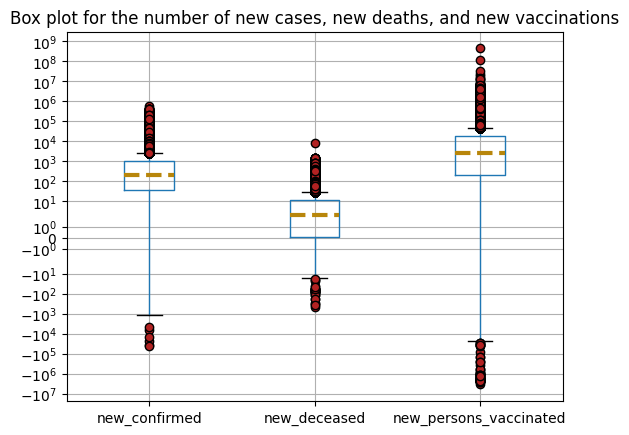

In [ ]:
merged_data_df.boxplot(["new_confirmed", "new_deceased", "new_persons_vaccinated"], flierprops={'marker': 'o', 'markersize': 6, 'markerfacecolor': 'firebrick'},
                  medianprops ={'linestyle':'--', 'linewidth':3, 'color':'darkgoldenrod'})
plt.yscale('symlog')
plt.title('Box plot for the number of new cases, new deaths, and new vaccinations')
plt.show()

1.4 Populacji

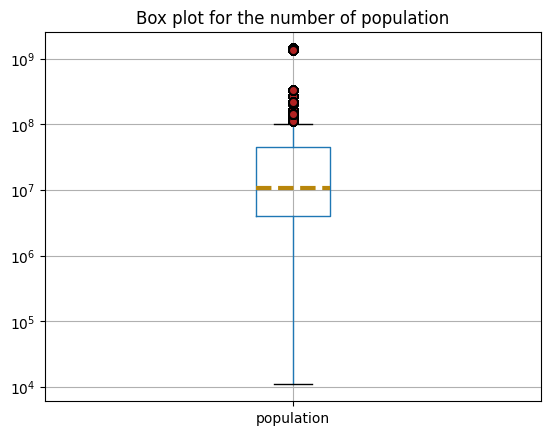

In [ ]:
merged_data_df = pd.read_csv('results\\prepared_for_2_ex.csv')

merged_data_df.boxplot(["population"], flierprops={'marker': 'o', 'markersize': 6, 'markerfacecolor': 'firebrick'},
                  medianprops ={'linestyle':'--', 'linewidth':3, 'color':'darkgoldenrod'})
plt.yscale('symlog')
plt.title('Box plot for the number of population')
plt.show()

1.5 PKB

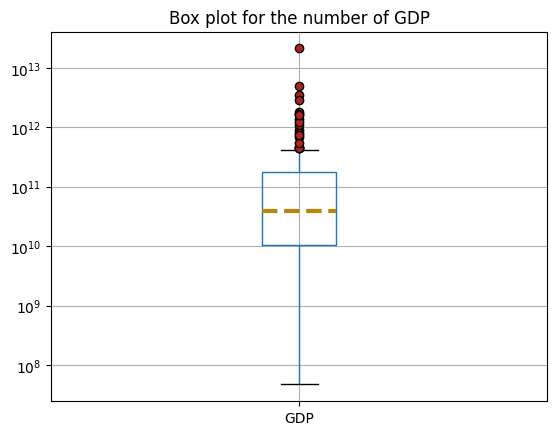

In [ ]:
merged_data_df = pd.read_csv('results\\prepared_for_2_ex.csv')
merged_data_df = merged_data_df.drop_duplicates(subset="country_name")
merged_data_df.boxplot(["GDP"], flierprops={'marker': 'o', 'markersize': 6, 'markerfacecolor': 'firebrick'},
                  medianprops ={'linestyle':'--', 'linewidth':3, 'color':'darkgoldenrod'})
plt.yscale('symlog')
plt.title('Box plot for the number of GDP')
plt.show()

1.6 -> 4 innych różnych informacji, które uznasz za istotne.

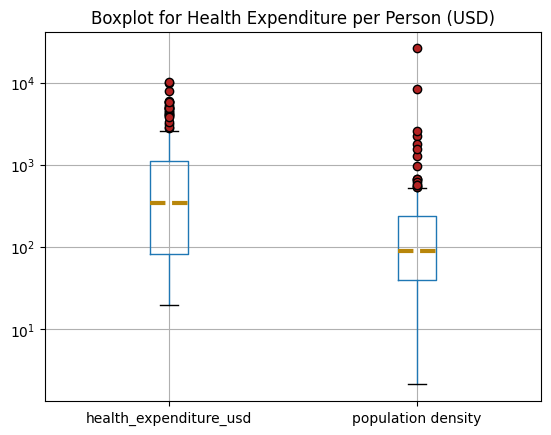

In [ ]:
merged_data_df.boxplot(["health_expenditure_usd", "population density"], flierprops={'marker': 'o', 'markersize': 6, 'markerfacecolor': 'firebrick'},
                  medianprops ={'linestyle':'--', 'linewidth':3, 'color':'darkgoldenrod'})
plt.yscale('symlog')
plt.title('Boxplot for Health Expenditure per Person (USD)')
plt.show()

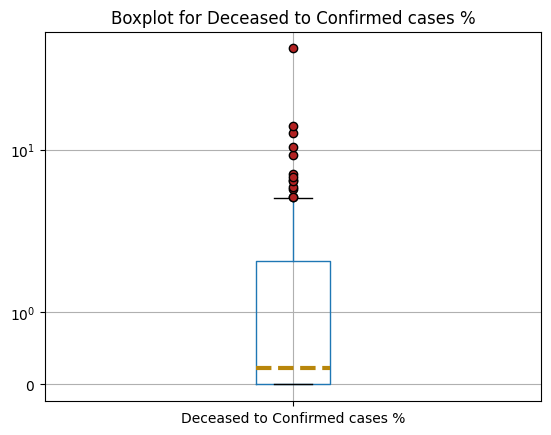

In [ ]:
merged_data_df.boxplot(["Deceased to Confirmed cases %"], flierprops={'marker': 'o', 'markersize': 6, 'markerfacecolor': 'firebrick'},
                  medianprops ={'linestyle':'--', 'linewidth':3, 'color':'darkgoldenrod'})

plt.yscale('symlog')
plt.title('Boxplot for Deceased to Confirmed cases %')
plt.show()

Część 3

Obliczenia statystyczne (m.in. średnia, mediana, moda, odchylenie standardowe) pozwolają na zrozumienie rozkładu danych oraz na identyfikację ewentualnych anomalii lub nietypowych wartości. 
Wykonaj następujące obliczenia:


3.1. średnia liczba nowych zachorowań, śmierci i szczepień dla co najmniej 10 wybranych krajów w wybranym miesiącu,

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


countries = ['Poland', 'Czech Republic', 'Germany', 'France', 'United Kingdom', 'Japan', 'Canada', 'Italy', 'Belgium', 'Denmark']


merged_covid_df = pd.read_csv('results\\prepared_for_2_ex.csv')
merged_covid_df['date'] = pd.to_datetime(merged_covid_df['date'])
df_filtered = merged_covid_df[(merged_covid_df['date'].dt.year == 2021) & (merged_covid_df['date'].dt.month == 10) & (merged_covid_df['country_name'].isin(countries))]

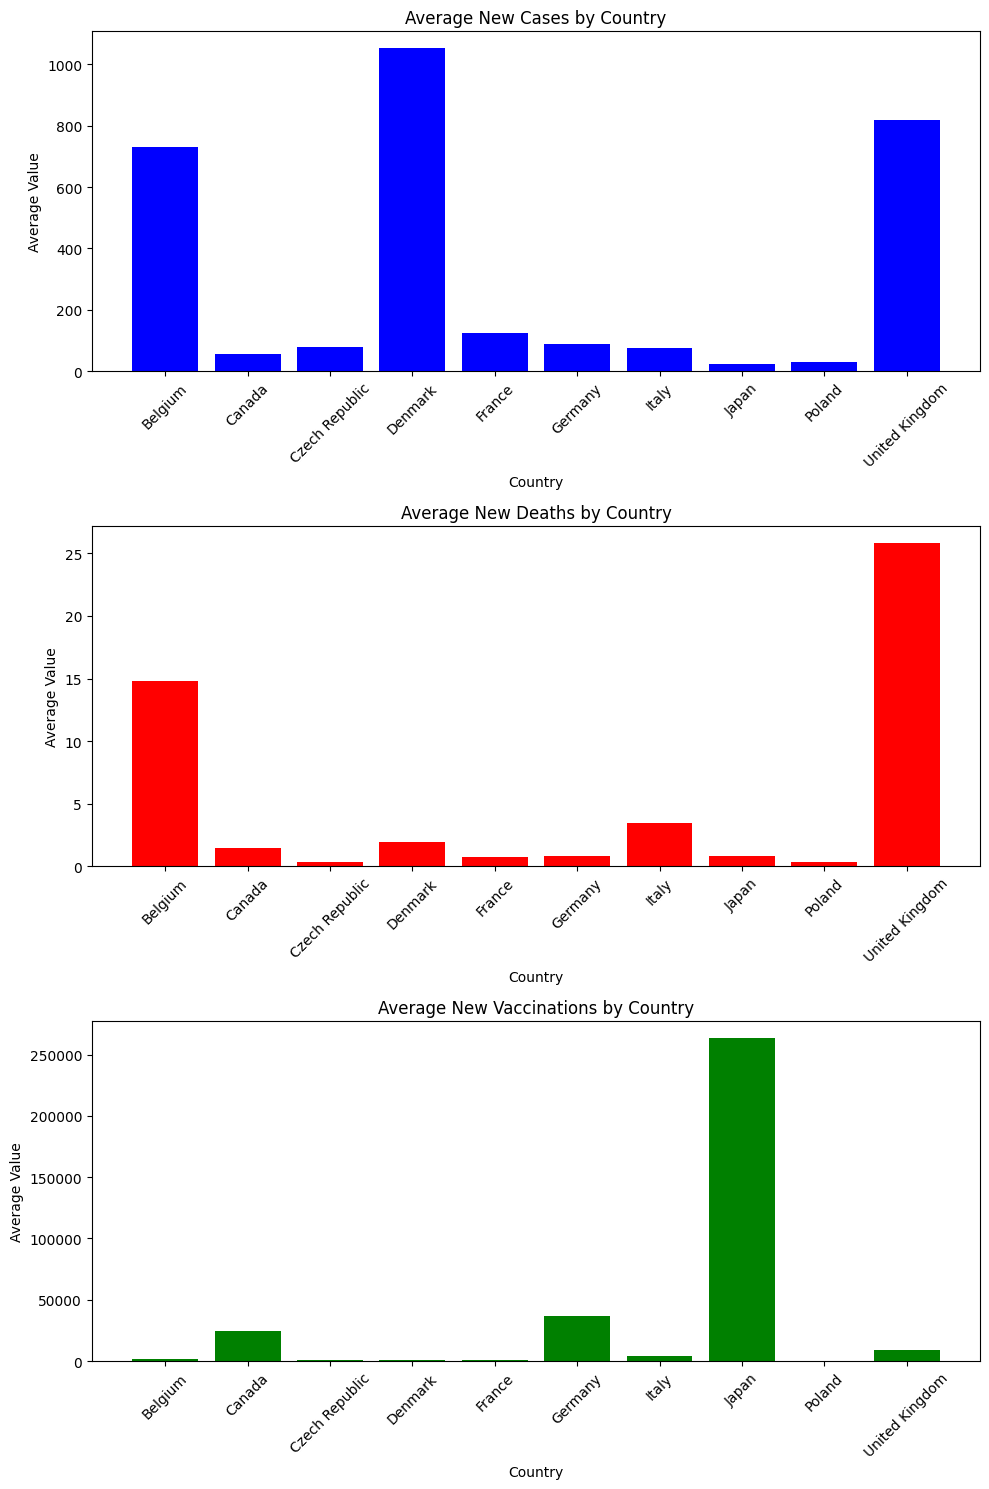

In [ ]:
avg_values = df_filtered.groupby(['country_name']).agg({'new_confirmed': 'mean', 'new_deceased': 'mean', 'new_persons_vaccinated': 'mean'})
avg_values.reset_index(inplace=True)

index = np.arange(len(avg_values['country_name']))

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

ax[0].bar(index, avg_values['new_confirmed'], color='blue', label='New cases')
ax[0].set_title('Average New Cases by Country')
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Average Value')
ax[0].set_xticks(index)
ax[0].set_xticklabels(avg_values['country_name'], rotation=45)

ax[1].bar(index, avg_values['new_deceased'], color='red', label='New deaths')
ax[1].set_title('Average New Deaths by Country')
ax[1].set_xlabel('Country')
ax[1].set_ylabel('Average Value')
ax[1].set_xticks(index)
ax[1].set_xticklabels(avg_values['country_name'], rotation=45)

ax[2].bar(index, avg_values['new_persons_vaccinated'], color='green', label='New vaccinations')
ax[2].set_title('Average New Vaccinations by Country')
ax[2].set_xlabel('Country')
ax[2].set_ylabel('Average Value')
ax[2].set_xticks(index)
ax[2].set_xticklabels(avg_values['country_name'], rotation=45)

plt.tight_layout()
plt.show()


3.2. średnia zmiana liczby zachorowań, śmierci i szczepień dla co najmniej 10 wybranych krajów w wybranym miesiącu

In [ ]:
import numpy as np

countries = ['Poland', 'Czech Republic', 'Germany', 'France', 'United Kingdom', 'Japan', 'Canada', 'Italy', 'Belgium', 'Denmark']


merged_covid_df = pd.read_csv('results\\prepared_for_2_ex.csv')
merged_covid_df['date'] = pd.to_datetime(merged_covid_df['date'])
df_filtered = merged_covid_df[(merged_covid_df['date'].dt.year == 2021) & (merged_covid_df['date'].dt.month == 10) & (merged_covid_df['country_name'].isin(countries))]

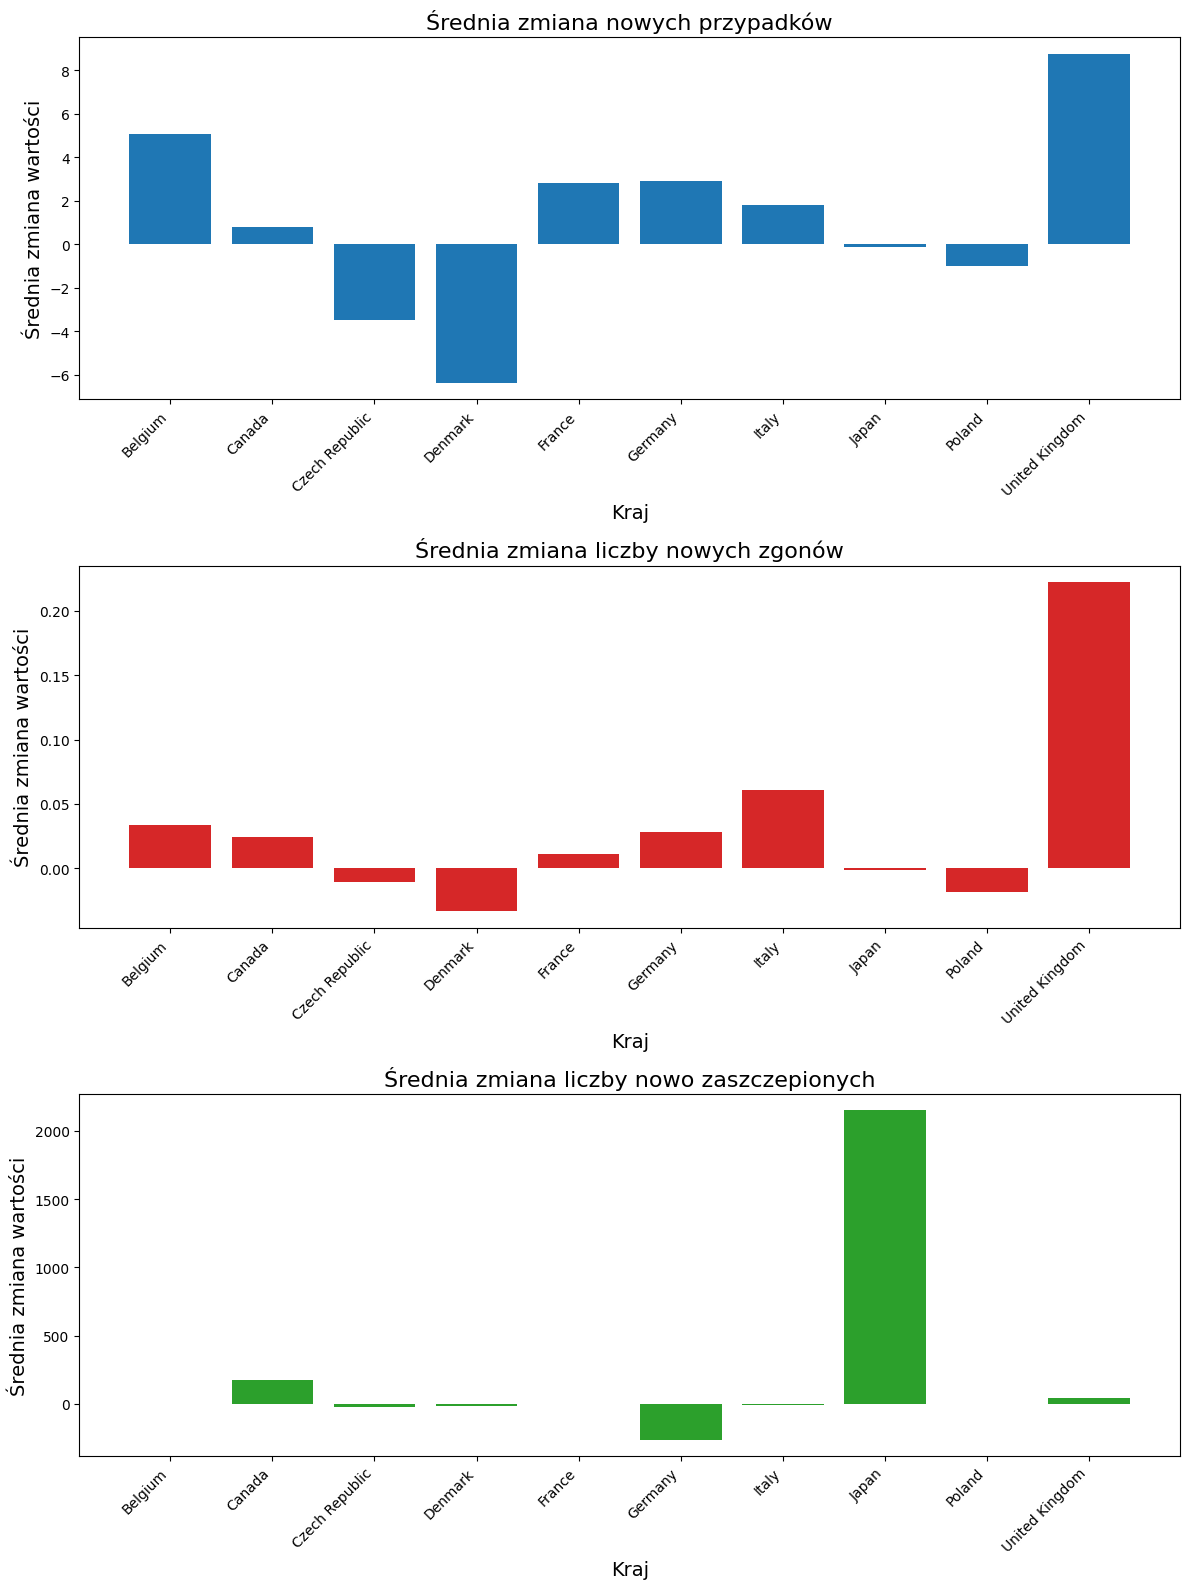

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

avg_diff_values = df_filtered.groupby('country_name')[['new_confirmed', 'new_deceased', 'new_persons_vaccinated']].diff()
avg_diff_values = avg_diff_values.groupby(df_filtered['country_name']).mean()
avg_diff_values.reset_index(inplace=True)

index = np.arange(len(avg_diff_values['country_name']))

fig, ax = plt.subplots(3, 1, figsize=(12, 16))

ax[0].bar(index, avg_diff_values['new_confirmed'], color='#1f77b4')
ax[0].set_title('Average change of new cases', fontsize=16)
ax[0].set_xlabel('Kraj', fontsize=14)
ax[0].set_ylabel('Average change in values', fontsize=14)
ax[0].set_xticks(index)
ax[0].set_xticklabels(avg_diff_values['country_name'], rotation=45, ha='right')

ax[1].bar(index, avg_diff_values['new_deceased'], color='#d62728')
ax[1].set_title('Average change of new deceased', fontsize=16)
ax[1].set_xlabel('Kraj', fontsize=14)
ax[1].set_ylabel('Average change in values', fontsize=14)
ax[1].set_xticks(index)
ax[1].set_xticklabels(avg_diff_values['country_name'], rotation=45, ha='right')

ax[2].bar(index, avg_diff_values['new_persons_vaccinated'], color='#2ca02c')
ax[2].set_title('Average change of new vaccinated', fontsize=16)
ax[2].set_xlabel('Kraj', fontsize=14)
ax[2].set_ylabel('Average change in values', fontsize=14)
ax[2].set_xticks(index)
ax[2].set_xticklabels(avg_diff_values['country_name'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


 3.3. mediana liczby nowych zachorowań, śmierci i szczepień dla co najmniej 10 wybranych krajów w wybranym miesiącu, 